# Comparison TPV tracks and MCS observations 

In [1]:
import re
import numpy as np
import pandas as pd
from tpv_analysis import get_tracks, check_overlap

## Get TPV tracks 

In [3]:
filename='tpv_files_JuliaK/tpv_2010.real_time'
tpv = get_tracks(filename, 2010)


## Get MCS tracks 

In [13]:
# read in CTT tracks heavy rain core 
tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tcs/Tracks_2015_heavyraincore3mmoccurrence.h5'
mcs= pd.read_hdf(tbb, 'table')
mcs.timestr = pd.to_datetime(mcs.timestr) 

## Overlap check for 16 years of TCS and TPV  

In [21]:
total_mcs= np.zeros((15,))
total_tpv= np.zeros((15,))
total_overlap= np.zeros((15,))

for y in np.arange(2001,2016):
    # tpv data 
    filename='tpv_files_JuliaK/tpv_' + str(y)+'.real_time'
    tpv = get_tracks(filename, y)
    
    # mcs data 
    tbb = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tcs/Tracks_'+ str(y)+ '_heavyraincore3mm.h5'
    mcs= pd.read_hdf(tbb, 'table')
    mcs.timestr = pd.to_datetime(mcs.timestr) 
    
    # overlap check 
    i = y - 2001
    mcs_count, no_mcs_count, no_tpv_count = check_overlap(tpv,mcs)
    total_mcs[i] = np.sum(mcs_count)
    total_tpv[i] = no_mcs_count
    total_overlap[i] =  no_tpv_count    

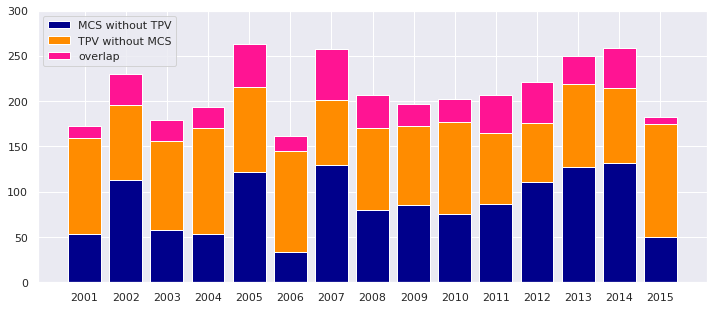

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
plt.figure(figsize= (12,5))
years = np.arange(2001,2016)

plt.bar(years, total_mcs, color = 'darkblue', label= 'MCS without TPV')
plt.bar(years,  total_tpv, bottom = total_mcs,color = 'darkorange', label = 'TPV without MCS')
plt.ylim(0,300)
plt.xticks(years)
plt.bar(years, total_overlap,bottom= total_mcs + total_tpv, color = 'deeppink', label = 'overlap')
plt.legend()
plt.show()

In [117]:
mcs_count, no_mcs_count, no_tpv_count = check_overlap(tpv,mcs)

In [121]:
no_tpv_count

663.0

In [118]:
mcs_count

array([ 0.,  0.,  2.,  0.,  4.,  5.,  3.,  4., 28., 65., 35.,  0.,  0.,
        1.,  0.])

- do the same per season 
- do it for complete data set 
- check what are the TPV that have multiple MCS associated with it 